### Credits

Nikita Kozodoi's [blog](https://kozodoi.me/python/time%20series/demand%20forecasting/competitions/2020/07/27/demand-forecasting.html) 

In [1]:
# Import Libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy.signal import find_peaks

from tsfresh import extract_features

import os
import time
import datetime
import random
import multiprocessing
import pickle

import gc
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option('display.max_columns', None)
%matplotlib inline
gc.enable()

### Load Data

In [6]:
infos  = pd.read_csv('infos.csv',  sep = '|')
items  = pd.read_csv('items.csv',  sep = '|')
orders = pd.read_csv('orders.csv', sep = '|')

print(infos.shape)
print(items.shape)
print(orders.shape)

(10463, 3)
(10463, 8)
(2181955, 5)


In [4]:
infos.head()

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN


In [5]:
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04


In [6]:
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [7]:
items = pd.merge(infos, items, on = 'itemID', how = 'left')
items.shape
del infos

In [8]:
items.head()

,itemID,simulationPrice,promotion,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,3.43,NaN,0,1,4.38,1,1,1,8.84
1,2,9.15,NaN,0,2,3.00,1,2,1,16.92
2,3,14.04,NaN,0,3,5.00,1,3,1,15.89
3,4,14.10,NaN,0,2,4.44,1,2,1,40.17
4,5,7.48,NaN,0,2,2.33,1,1,1,17.04


In [9]:
# Convert features into str object

print('-' * 50)
print(items.dtypes)
print('-' * 50)
print(orders.dtypes)
print('-' * 50)

--------------------------------------------------
itemID                      int64
simulationPrice           float64
promotion                  object
brand                       int64
manufacturer                int64
customerRating            float64
category1                   int64
category2                   int64
category3                   int64
recommendedRetailPrice    float64
dtype: object
--------------------------------------------------
time           object
transactID      int64
itemID          int64
order           int64
salesPrice    float64
dtype: object
--------------------------------------------------


In [12]:
items['itemID'].nunique()

10463

In [11]:
# items
for var in ['itemID', 'brand', 'manufacturer', 'category1', 'category2', 'category3']:
    items[var] = items[var].astype('str').astype('object') 
    
# orders
for var in ['transactID', 'itemID']:
    orders[var] = orders[var].astype('str').astype('object') 
    
# dates
orders['time'] = pd.to_datetime(orders['time'].astype('str'), infer_datetime_format = True)

In [5]:
# split nested promotion feature

df_new = items.copy()
n_feats = df_new.shape[1]
split_vars = 'promotion'

if not isinstance(split_vars, list):
    split_vars = [split_vars]

for split_var in split_vars:
    
    max_values = int(df_new[split_var].str.count(',').max() + 1)
    new_vars = [split_var + '_' + str(val) for val in range(max_values)]
    
    cols_without_split = [col for col in df_new.columns if col not in split_var]

    df_new = pd.concat([df_new[cols_without_split], df_new[split_var].str.split(',', expand = True)], axis = 1)
    df_new.columns = cols_without_split + new_vars
   
items = df_new
items.shape

(10463, 12)

In [11]:
items.head()

,itemID,simulationPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,promotion_0,promotion_1,promotion_2
0,1,3.43,0,1,4.38,1,1,1,8.84,NaN,NaN,NaN
1,2,9.15,0,2,3.00,1,2,1,16.92,NaN,NaN,NaN
2,3,14.04,0,3,5.00,1,3,1,15.89,NaN,NaN,NaN
3,4,14.10,0,2,4.44,1,2,1,40.17,NaN,NaN,NaN
4,5,7.48,0,2,2.33,1,1,1,17.04,NaN,NaN,NaN


### Date format conversion

In [49]:
# convert dates
promotion_vars = items.filter(like = 'promotion_').columns
for var in promotion_vars:
    items[var] = pd.to_datetime(items[var], infer_datetime_format = True)
items.dtypes

itemID                                         int64
simulationPrice                              float64
brand                                          int64
manufacturer                                   int64
customerRating                               float64
category1                                      int64
category2                                      int64
category3                                      int64
recommendedRetailPrice                       float64
promotion_0                           datetime64[ns]
promotion_1                           datetime64[ns]
promotion_2                           datetime64[ns]
recommended_simulation_price_ratio           float64
category                                       int32
customerRating_manufacturer_ratio            float64
customerRating_category_ratio                float64
dtype: object

In [6]:
orders['time'] = pd.to_datetime(orders['time'].astype('str'))

In [11]:
orders.dtypes

time          datetime64[ns]
transactID             int64
itemID                 int64
order                  int64
salesPrice           float64
dtype: object

### Price ratio

In [44]:
# price ratio
items['recommended_simulation_price_ratio'] = items['simulationPrice'] / items['recommendedRetailPrice']
items['recommended_simulation_price_ratio'].describe()

count    10463.000000
mean         0.957107
std          0.616878
min          0.020094
25%          0.449184
50%          0.813378
75%          1.359211
max          5.678983
Name: recommended_simulation_price_ratio, dtype: float64

### Unique item categories

In [45]:
# detailed item category
items['category'] = items['category1'].astype(str) + items['category2'].astype(str) + items['category3'].astype(str)
items['category'] = items['category'].astype(int)
items['category'].nunique()

75

### Customer rating ratio per manufacturer

In [46]:
# customer rating ratio per manufacturer
rating_manufacturer = items.groupby('manufacturer')['customerRating'].agg('mean').reset_index()
rating_manufacturer.columns = ['manufacturer', 'mean_customerRating_manufacturer']
items = items.merge(rating_manufacturer, how = 'left', on = 'manufacturer')
items['customerRating_manufacturer_ratio'] = items['customerRating'] / items['mean_customerRating_manufacturer']
del items['mean_customerRating_manufacturer']
items['customerRating_manufacturer_ratio'].describe()

count    10272.000000
mean         1.000000
std          2.015833
min          0.000000
25%          0.000000
50%          0.000000
75%          1.689412
max         26.458333
Name: customerRating_manufacturer_ratio, dtype: float64

### Customer rating ratio per category

In [47]:
# customer rating ratio per category
rating_category = items.groupby('category')['customerRating'].agg('mean').reset_index()
rating_category.columns = ['category', 'mean_customerRating_category']
items = items.merge(rating_category, how = 'left', on = 'category')
items['customerRating_category_ratio'] = items['customerRating'] / items['mean_customerRating_category']
del items['mean_customerRating_category']
items['customerRating_category_ratio'].describe()

count    10444.000000
mean         1.000000
std          1.857433
min          0.000000
25%          0.000000
50%          0.000000
75%          1.932587
max         51.666667
Name: customerRating_category_ratio, dtype: float64

### Aggregating Orders & Mean of Sales Price

In [10]:
orders['day_of_year'] = orders['time'].dt.dayofyear
orders_price = orders.groupby(['itemID', 'day_of_year'])['salesPrice'].agg('mean').reset_index()
orders = orders.groupby(['itemID', 'day_of_year'])['order'].agg('sum').reset_index()
orders.head()

,itemID,day_of_year,order
0,1,23,1
1,1,25,1
2,1,29,307
3,1,30,3
4,1,31,1


In [8]:
orders_price.head()

,itemID,day_of_year,salesPrice
0,1,23,3.11
1,1,25,3.11
2,1,29,3.11
3,1,30,3.11
4,1,31,3.11


### Add zeros for days with no transactions

In [11]:
# add items that were never sold before
missing_itemIDs = set(items['itemID'].unique()) - set(orders['itemID'].unique())
missing_rows = pd.DataFrame({'itemID':     list(missing_itemIDs), 
                            'day_of_year': np.ones(len(missing_itemIDs)).astype('int'), 
                            'order':       np.zeros(len(missing_itemIDs)).astype('int')})
orders = pd.concat([orders, missing_rows], axis = 0)
print(orders.shape)

# add zeros for days with no transactions
agg_orders = orders.groupby(['itemID', 'day_of_year']).order.unique().unstack('day_of_year').stack('day_of_year', dropna = False)
agg_orders = agg_orders.reset_index()
agg_orders.columns = ['itemID', 'day_of_year', 'order']
agg_orders['order'].fillna(0, inplace = True)
agg_orders['order'] = agg_orders['order'].astype(int)
print(agg_orders.shape)

(100771, 3)
(1883340, 3)


In [12]:
agg_orders.head()

,itemID,day_of_year,order
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,0


### Fill missing prices for dates with no orders

In [13]:
##### ADD MISSING INPUTS [PRICES]

# add items that were never sold before
missing_rows = pd.DataFrame({'itemID':     list(missing_itemIDs), 
                            'day_of_year': np.ones(len(missing_itemIDs)).astype('int'), 
                            'salesPrice':  np.zeros(len(missing_itemIDs)).astype('int')})
orders_price = pd.concat([orders_price, missing_rows], axis = 0)
print(orders_price.shape)

# add zeros for days with no transactions
agg_orders_price = orders_price.groupby(['itemID', 'day_of_year']).salesPrice.unique().unstack('day_of_year').stack('day_of_year', dropna = False)
agg_orders_price = agg_orders_price.reset_index()
agg_orders_price.columns = ['itemID', 'day_of_year', 'salesPrice']
agg_orders_price['salesPrice'].fillna(0, inplace = True)
agg_orders_price['salesPrice'] = agg_orders_price['salesPrice'].astype(int)
agg_orders_price['salesPrice'][agg_orders_price['salesPrice'] == 0] = np.nan
print(agg_orders_price.shape)

# fill missing prices for dates with no orders
agg_orders_price['salesPrice'] = agg_orders_price.groupby(['itemID']).salesPrice.fillna(method = 'ffill')
agg_orders_price['salesPrice'] = agg_orders_price.groupby(['itemID']).salesPrice.fillna(method = 'bfill')
agg_orders_price = agg_orders_price.merge(items[['itemID', 'simulationPrice']], how = 'left', on = 'itemID')
agg_orders_price['salesPrice'][agg_orders_price['salesPrice'].isnull()] = agg_orders_price['simulationPrice'][agg_orders_price['salesPrice'].isnull()]
del agg_orders_price['simulationPrice']

# merge prices to orders
agg_orders = agg_orders.merge(agg_orders_price, how = 'left', on = ['itemID', 'day_of_year'])
print(agg_orders.shape)

(100771, 3)
(1883340, 3)
(1883340, 4)


In [14]:
agg_orders.head()

,itemID,day_of_year,order,salesPrice
0,1,1,0,3.0
1,1,2,0,3.0
2,1,3,0,3.0
3,1,4,0,3.0
4,1,5,0,3.0


In [15]:
agg_orders.to_csv('agg_orders.csv')

### Isolate peaks in the order df and encode them as promotions:

In [24]:
# computations
agg_orders['promotion'] = 0
for itemID in tqdm(agg_orders['itemID'].unique()):
    promo    = np.zeros(len(agg_orders[agg_orders['itemID'] == itemID])) # array of 0 of len 180
    avg      = agg_orders[(agg_orders['itemID'] == itemID)]['order'].median()
    std      = agg_orders[(agg_orders['itemID'] == itemID)]['order'].std()
    peaks, _ = find_peaks(np.append(agg_orders[agg_orders['itemID'] == itemID]['order'].values, avg), # append avg to enable marking last point as promo
                          prominence = max(5, std),  # peak difference with neighbor points; max(5,std) to exclude cases when std is too small
                          height     = avg + 2*std)  # minimal height of a peak
    promo[peaks] = 1
    agg_orders.loc[agg_orders['itemID'] == itemID, 'promotion'] = promo

# check total promotions
print(agg_orders['promotion'].sum())

100%|████████████████████████████████████████████████████████████████████████████| 10463/10463 [03:23<00:00, 51.42it/s]

14911


In [25]:
agg_orders.head(20)

,itemID,day_of_year,order,salesPrice,promotion
0,1,1,0,3.0,0
1,1,2,0,3.0,0
2,1,3,0,3.0,0
3,1,4,0,3.0,0
4,1,5,0,3.0,0
5,1,6,0,3.0,0
6,1,7,0,3.0,0
7,1,8,0,3.0,0
8,1,9,0,3.0,0
9,1,10,0,3.0,0


In [32]:
agg_orders.shape

(1883340, 5)

### Compare promotion number

In [25]:
# compare promotion number
promo_in_train = (agg_orders['promotion'].sum() / agg_orders['day_of_year'].max()) / len(items)
promo_in_test  = (3*len(df_new) - df_new.promotion_0.isnull().sum() - df_new.promotion_2.isnull().sum() - df_new.promotion_1.isnull().sum()) / 14 / len(df_new)
print('Daily p(promotion) per item in train: {}'.format(np.round(promo_in_train, 4)))
print('Daily p(promotion) per item in test:  {}'.format(np.round(promo_in_test , 4)))

Daily p(promotion) per item in train: 0.0079
Daily p(promotion) per item in test:  0.0141


In [19]:
agg_orders.to_pickle('prepared/agg_orders.pkl')

### Create new features

In [36]:
from tsfresh.feature_extraction import extract_features

fc_parameters = {
    'variance_larger_than_standard_deviation': None, 
    'has_duplicate_max': None, 
    'has_duplicate_min': None, 
    'has_duplicate': None, 
    'sum_values': None, 
    'abs_energy': None, 
    'mean_abs_change': None, 
    'mean_change': None, 
    'mean_second_derivative_central': None, 
    'median': None, 
    'mean': None, 
    'length': None, 
    'standard_deviation': None, 
    'variation_coefficient': None, 
    'variance': None, 'skewness': None, 
    'kurtosis': None, 'root_mean_square': None, 
    'absolute_sum_of_changes': None, 
    'longest_strike_below_mean': None, 
    'longest_strike_above_mean': None, 
    'count_above_mean': None, 
    'count_below_mean': None, 
    'last_location_of_maximum': None, 
    'first_location_of_maximum': None, 
    'last_location_of_minimum': None, 
    'first_location_of_minimum': None, 
    'percentage_of_reoccurring_values_to_all_values': None, 
    'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 
    'sum_of_reoccurring_values': None, 
    'sum_of_reoccurring_data_points': None, 
    'ratio_value_number_to_time_series_length': None, 
    'sample_entropy': None, 
    'maximum': None, 
    'absolute_maximum': None, 
    'minimum': None, 
    'benford_correlation': None,
    'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 
    'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], 
    'cid_ce': [{'normalize': True}, {'normalize': False}],    
    'quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}, {'q': 0.4}, {'q': 0.6}, {'q': 0.7}, {'q': 0.8}, {'q': 0.9}],
    'autocorrelation': [{'lag': 0}, {'lag': 1}, {'lag': 2}, {'lag': 3}, {'lag': 4}, {'lag': 5}, {'lag': 6}, {'lag': 7}, {'lag': 8}, {'lag': 9}],
    'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40}, {'f_agg': 'median', 'maxlag': 40}, {'f_agg': 'var', 'maxlag': 40}],
    'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
    'fft_aggregated': [{'aggtype': 'centroid'}, {'aggtype': 'variance'}, {'aggtype': 'skew'}, {'aggtype': 'kurtosis'}]
}

In [37]:

# parameters
days_input  = [1, 7, 14, 21, 28, 35]
days_target = 14

# preparations
day_first = np.max(days_input)
day_last  = agg_orders['day_of_year'].max() - days_target + 1  # 180 - 14 + 1
orders    = None

# merge manufacturer and category
agg_orders = agg_orders.merge(items[['itemID', 'manufacturer']], how = 'left')
agg_orders = agg_orders.merge(items[['itemID', 'category']],     how = 'left')

# computations
# for day_of_year in tqdm(list(range(149, 167)) + [180]) ie list(149, to 167,180)
for day_of_year in tqdm(list(range(1, day_last)) + [agg_orders['day_of_year'].max()]):

    ### VALIDAION: TARGET, PROMOTIONS, PRICES
        
    # day intervals list(149, to 167,180)
    target_day_min = day_of_year + 1    
    target_day_max = day_of_year + days_target
    
    # compute target and promo: labeled data
    if day_of_year < agg_orders['day_of_year'].max():
        
        # target and future promo
        tmp_df = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                            (agg_orders['day_of_year'] <= target_day_max)
                           ].groupby('itemID')['order', 'promotion'].agg('sum').reset_index()
        tmp_df.columns = ['itemID', 'target', 'promo_in_test']
        
        # future price
        tmp_df['mean_price_test'] = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                               (agg_orders['day_of_year'] <= target_day_max)
                                              ].groupby('itemID')['salesPrice'].agg('mean').reset_index()['salesPrice']
        
        # merge manufacturer and category
        tmp_df = tmp_df.merge(items[['itemID', 'manufacturer', 'category']], how = 'left', on = 'itemID')
        
        # future price per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['salesPrice'].agg('mean').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'mean_price_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
        
        # future price per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['salesPrice'].agg('mean').reset_index()
        tmp_df_category.columns = ['category', 'mean_price_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
        
        # future promo per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['promotion'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'promo_in_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')

        # future promo per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['promotion'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'promo_in_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
                       
        
    # compute target and promo: unlabeled data
    else:
        
        # placeholders
        tmp_df = pd.DataFrame({'itemID':                     items.itemID,
                               'target':                     np.nan,
                               'promo_in_test':              np.nan,
                               'mean_price_test':            items.simulationPrice,
                               'manufacturer':               items.manufacturer,
                               'category':                   items.category,
                               'promo_in_test_manufacturer': np.nan,
                               'promo_in_test_category':     np.nan})

        
    ### TRAINING: LAG-BASED FEATURES
            
    # compute features
    for day_input in days_input:
        
        # day intervals
        input_day_min  = day_of_year - day_input + 1
        input_day_max  = day_of_year
    
        # frequency, promo and price
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('itemID')
        tmp_df['order_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum').reset_index()['order']
        tmp_df['order_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df['promo_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df['mean_price_last_'  + str(day_input)] = tmp_df_input['salesPrice'].agg('mean').reset_index()['salesPrice']

        # frequency, promo per manufacturer
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('manufacturer')
        tmp_df_manufacturer = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'order_manufacturer_sum_last_' + str(day_input)]
        tmp_df_manufacturer['order_manufacturer_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_manufacturer['promo_manufacturer_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
    
        # frequency, promo per category
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('category')
        tmp_df_category = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'order_category_sum_last_' + str(day_input)]       
        tmp_df_category['order_category_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_category['promo_category_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')

        # frequency, promo per all items
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)]
        tmp_df['order_all_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum')
        tmp_df['order_all_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0]))
        tmp_df['promo_all_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum')
        
        # recency
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max) &
                                      (agg_orders['order'] > 0)
                                     ].groupby('itemID')
            tmp_df['days_since_last_order'] = (day_of_year - tmp_df_input['day_of_year'].agg('max')).reindex(tmp_df.itemID).reset_index()['day_of_year']
            tmp_df['days_since_last_order'].fillna(day_input, inplace = True)
            
            
        # tsfresh features
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max)]
            tmp_df_input = tmp_df_input[['day_of_year', 'itemID', 'order']]
            extracted_features = extract_features(tmp_df_input, column_id = 'itemID', column_sort = 'day_of_year',
                                                 default_fc_parameters=fc_parameters)
            extracted_features['itemID'] = extracted_features.index
            tmp_df = tmp_df.merge(extracted_features, how = 'left', on = 'itemID')
            
            
    ### FINAL PREPARATIONS
            
    # day of year
    tmp_df.insert(1, column = 'day_of_year', value = day_of_year)
        
    # merge data
    orders = pd.concat([orders, tmp_df], axis = 0)
    
    # drop manufacturer and category
    del orders['manufacturer']
    del orders['category']


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [3:07:52<00:00, 67.50s/it]


In [39]:
orders.head()

,itemID,day_of_year,target,promo_in_test,mean_price_test,mean_price_test_manufacturer,mean_price_test_category,promo_in_test_manufacturer,promo_in_test_category,order_sum_last_1,order_count_last_1,promo_count_last_1,mean_price_last_1,order_manufacturer_sum_last_1,order_manufacturer_count_last_1,promo_manufacturer_count_last_1,order_category_sum_last_1,order_category_count_last_1,promo_category_count_last_1,order_all_sum_last_1,order_all_count_last_1,promo_all_count_last_1,order_sum_last_7,order_count_last_7,promo_count_last_7,mean_price_last_7,order_manufacturer_sum_last_7,order_manufacturer_count_last_7,promo_manufacturer_count_last_7,order_category_sum_last_7,order_category_count_last_7,promo_category_count_last_7,order_all_sum_last_7,order_all_count_last_7,promo_all_count_last_7,order_sum_last_14,order_count_last_14,promo_count_last_14,mean_price_last_14,order_manufacturer_sum_last_14,order_manufacturer_count_last_14,promo_manufacturer_count_last_14,order_category_sum_last_14,order_category_count_last_14,promo_category_count_last_14,order_all_sum_last_14,order_all_count_last_14,promo_all_count_last_14,order_sum_last_21,order_count_last_21,promo_count_last_21,mean_price_last_21,order_manufacturer_sum_last_21,order_manufacturer_count_last_21,promo_manufacturer_count_last_21,order_category_sum_last_21,order_category_count_last_21,promo_category_count_last_21,order_all_sum_last_21,order_all_count_last_21,promo_all_count_last_21,order_sum_last_28,order_count_last_28,promo_count_last_28,mean_price_last_28,order_manufacturer_sum_last_28,order_manufacturer_count_last_28,promo_manufacturer_count_last_28,order_category_sum_last_28,order_category_count_last_28,promo_category_count_last_28,order_all_sum_last_28,order_all_count_last_28,promo_all_count_last_28,order_sum_last_35,order_count_last_35,promo_count_last_35,mean_price_last_35,order_manufacturer_sum_last_35,order_manufacturer_count_last_35,promo_manufacturer_count_last_35,order_category_sum_last_35,order_category_count_last_35,promo_category_count_last_35,order_all_sum_last_35,order_all_count_last_35,promo_all_count_last_35,days_since_last_order,order__variance_larger_than_standard_deviation,order__has_duplicate_max,order__has_duplicate_min,order__has_duplicate,order__sum_values,order__abs_energy,order__mean_abs_change,order__mean_change,order__mean_second_derivative_central,order__median,order__mean,order__length,order__standard_deviation,order__variation_coefficient,order__variance,order__skewness,order__kurtosis,order__root_mean_square,order__absolute_sum_of_changes,order__longest_strike_below_mean,order__longest_strike_above_mean,order__count_above_mean,order__count_below_mean,order__last_location_of_maximum,order__first_location_of_maximum,order__last_location_of_minimum,order__first_location_of_minimum,order__percentage_of_reoccurring_values_to_all_values,order__percentage_of_reoccurring_datapoints_to_all_datapoints,order__sum_of_reoccurring_values,order__sum_of_reoccurring_data_points,order__ratio_value_number_to_time_series_length,order__sample_entropy,order__maximum,order__absolute_maximum,order__minimum,order__benford_correlation,order__time_reversal_asymmetry_statistic__lag_1,order__time_reversal_asymmetry_statistic__lag_2,order__time_reversal_asymmetry_statistic__lag_3,order__c3__lag_1,order__c3__lag_2,order__c3__lag_3,order__cid_ce__normalize_True,order__cid_ce__normalize_False,order__quantile__q_0.1,order__quantile__q_0.2,order__quantile__q_0.3,order__quantile__q_0.4,order__quantile__q_0.6,order__quantile__q_0.7,order__quantile__q_0.8,order__quantile__q_0.9,order__autocorrelation__lag_0,order__autocorrelation__lag_1,order__autocorrelation__lag_2,order__autocorrelation__lag_3,order__autocorrelation__lag_4,order__autocorrelation__lag_5,order__autocorrelation__lag_6,order__autocorrelation__lag_7,order__autocorrelation__lag_8,order__autocorrelation__lag_9,"order__agg_autocorrelation__f_agg_""mean""__maxlag_40","order__agg_autocorrelation__f_agg_""median""__maxlag_40","

In [38]:
orders.shape

(1747321, 163)

In [40]:
orders.to_pickle('prepared/feat_orders.pkl')

In [3]:
orders = pd.read_pickle(r'prepared/feat_orders.pkl')
orders.shape

(1747321, 163)

In [4]:
# count missing values
total = orders.isnull().sum().sort_values(ascending = False)
percent = (orders.isnull().sum() / orders.isnull().count()).sort_values(ascending = False)
table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
table = table[table['Total'] > 0]

# return results
if len(table) > 0:
    print('Found {} features with missing values.'.format(len(table)))
    print(table) 
else:
    print('No missing values found.')

Found 28 features with missing values.
                                             Total   Percent
order__autocorrelation__lag_9              1108470  0.634383
order__autocorrelation__lag_8              1107203  0.633657
order__autocorrelation__lag_7              1106035  0.632989
order__autocorrelation__lag_6              1104957  0.632372
order__autocorrelation__lag_5              1103977  0.631811
order__autocorrelation__lag_4              1103121  0.631321
order__fft_aggregated__aggtype_"kurtosis"  1102513  0.630973
order__fft_aggregated__aggtype_"skew"      1102513  0.630973
order__autocorrelation__lag_3              1102425  0.630923
order__autocorrelation__lag_2              1101851  0.630594
order__autocorrelation__lag_0              1101445  0.630362
order__autocorrelation__lag_1              1101445  0.630362
order__fft_aggregated__aggtype_"centroid"  1101211  0.630228
order__fft_aggregated__aggtype_"variance"  1101211  0.630228
order__variation_coefficient               110

In [5]:
len(list(orders.columns[orders.isnull().sum() == 0]))

135

In [6]:
##### REMOVE MISSINGS

good_nan = ['target', 
            'mean_price_test_category', 'mean_price_test_manufacturer',
            'promo_in_test', 'promo_in_test_category', 'promo_in_test_manufacturer']

no_nan = list(orders.columns[orders.isnull().sum() == 0]) + good_nan
orders = orders[no_nan]
print(orders.shape)

(1747321, 141)


In [7]:
##### COMPUTE MEAN PRICE RATIOS

print(orders.shape)
price_vars = ['mean_price_last_1', 'mean_price_last_7', 'mean_price_last_14', 
              'mean_price_last_21', 'mean_price_last_28', 'mean_price_last_35']
for var in price_vars:
    orders['ratio_'              + str(var)] = orders['mean_price_test']              / orders[var]
    orders['ratio_manufacturer_' + str(var)] = orders['mean_price_test_manufacturer'] / orders[var]
    orders['ratio_category_'     + str(var)] = orders['mean_price_test_category']     / orders[var]
print(orders.shape)

(1747321, 141)
(1747321, 159)


Text(0.5, 0, 'Day')

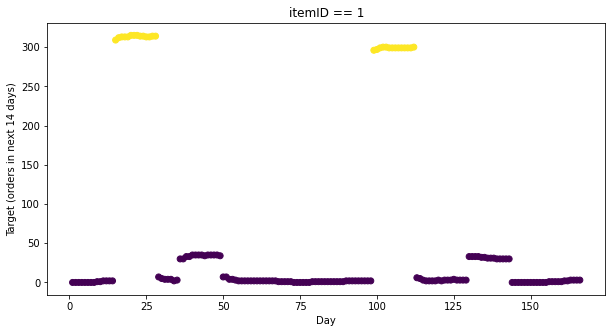

In [8]:
# example sales plot
df = orders[orders.itemID == 1]
plt.figure(figsize = (10, 5))
plt.scatter(df['day_of_year'], df['target'], c = df['promo_in_test'])
plt.title('itemID == 1')
plt.ylabel('Target (orders in next 14 days)')
plt.xlabel('Day')

In [9]:
# Spot the categorical feature pairs with high correlation

threshold = 0.9999
corr = orders.corr()
high_corrs = (corr[abs(corr) > threshold][corr != 1.0]).unstack().dropna().to_dict()
unique_high_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), high_corrs[key]) for key in high_corrs])), columns=['feature_pair', 'correlation_coefficient'])
unique_high_corrs = unique_high_corrs.loc[abs(unique_high_corrs['correlation_coefficient']).argsort()[::-1]]
pd.options.display.max_colwidth = 200
unique_high_corrs

,feature_pair,correlation_coefficient
0,"(mean_price_last_28, mean_price_last_35)",0.999966
4,"(mean_price_last_21, mean_price_last_28)",0.999952
3,"(mean_price_last_14, mean_price_last_21)",0.999935
2,"(ratio_manufacturer_mean_price_last_28, ratio_manufacturer_mean_price_last_35)",0.999910
5,"(ratio_category_mean_price_last_28, ratio_category_mean_price_last_35)",0.999907
1,"(mean_price_last_14, mean_price_last_7)",0.999901


In [11]:
items  = pd.read_csv('prepared/items_v1.csv',  compression = 'gzip')
items.shape

(10463, 12)

In [20]:
items.columns

Index(['itemID', 'simulationPrice', 'brand', 'manufacturer', 'customerRating',
       'category1', 'category2', 'category3', 'recommendedRetailPrice',
       'promotion_0', 'promotion_1', 'promotion_2'],
      dtype='object')

In [12]:
df = pd.merge(orders, items, on = 'itemID', how = 'left')
df.shape

(1747321, 170)

In [13]:
# partition intro train and test
df_train = df[df['day_of_year'] <  df['day_of_year'].max()]
df_test  = df[df['day_of_year'] == df['day_of_year'].max()]
print(df_train.shape)
print(df_test.shape)

(1736858, 170)
(10463, 170)


In [17]:
print(df_train.shape)
print(df_test.shape)

(1736858, 170)
(10463, 169)


### Compute features for Test

In [14]:
# add promotion info to test

promo_vars = df_test.filter(like = 'promotion_').columns
df_test['promo_in_test'] = 3 - df_test[promo_vars].isnull().sum(axis = 1)
df_test['promo_in_test'].describe()

count    10463.000000
mean         0.197458
std          0.455436
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: promo_in_test, dtype: float64

In [15]:
### PROMO PER MANUFACTURER, CATEGORY

del df_test['promo_in_test_manufacturer'], df_test['promo_in_test_category']

# future promo per manufacturer
tmp_df_manufacturer = df_test.groupby('manufacturer')['promo_in_test'].agg('sum').reset_index()
tmp_df_manufacturer.columns = ['manufacturer', 'promo_in_test_manufacturer']
df_test = df_test.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
print(df_test.shape)

(10463, 169)


In [21]:

# detailed item category
df_test['category'] = df_test['category1'].astype(str) + df_test['category2'].astype(str) + df_test['category3'].astype(str)
df_test['category'] = df_test['category'].astype(int)

In [22]:
tmp_df_category = df_test.groupby('category')['promo_in_test'].agg('sum').reset_index()
tmp_df_category.columns = ['category', 'promo_in_test_category']
df_test = df_test.merge(tmp_df_category, how = 'left', on = 'category')
print(df_test.shape)

(10463, 171)


In [23]:
### PRICE PER MANUFACTURER, CATEGORY

del df_test['mean_price_test_manufacturer'], df_test['mean_price_test_category']

# future price per manufacturer
tmp_df_manufacturer = df_test.groupby('manufacturer')['mean_price_test'].agg('mean').reset_index()
tmp_df_manufacturer.columns = ['manufacturer', 'mean_price_test_manufacturer']
df_test = df_test.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
print(df_test.shape)

(10463, 170)


In [24]:
# future price per category
tmp_df_category = df_test.groupby('category')['mean_price_test'].agg('mean').reset_index()
tmp_df_category.columns = ['category', 'mean_price_test_category']
df_test = df_test.merge(tmp_df_category, how = 'left', on = 'category')
print(df_test.shape)

(10463, 171)


In [25]:
### MEAN PRICE RATIOS

for var in price_vars:
    df_test['ratio_'              + str(var)] = df_test['mean_price_test']              / df_test[var]
    df_test['ratio_manufacturer_' + str(var)] = df_test['mean_price_test_manufacturer'] / df_test[var]
    df_test['ratio_category_'     + str(var)] = df_test['mean_price_test_category']     / df_test[var]
print(df_test.shape)

(10463, 171)


In [30]:
list(set(df_test.columns) - set(df_train.columns))

['category']

In [31]:
list(set(df_train.columns) - set(df_test.columns))

[]

In [32]:
del df_test['category']

In [33]:
list(set(df_test.columns) - set(df_train.columns))

[]

In [34]:
df_train.to_pickle('prepared/df_train.pkl')
df_test.to_pickle('prepared/df_test.pkl')

## Modeling

In [3]:
df_train = pd.read_pickle(r'prepared/df_train.pkl')
df_test = pd.read_pickle(r'prepared/df_test.pkl')
print(df_train.shape)
print(df_test.shape)

(1736858, 170)
(10463, 170)


In [4]:
df_train.head()

,itemID,day_of_year,mean_price_test,order_sum_last_1,order_count_last_1,promo_count_last_1,mean_price_last_1,order_manufacturer_sum_last_1,order_manufacturer_count_last_1,promo_manufacturer_count_last_1,order_category_sum_last_1,order_category_count_last_1,promo_category_count_last_1,order_all_sum_last_1,order_all_count_last_1,promo_all_count_last_1,order_sum_last_7,order_count_last_7,promo_count_last_7,mean_price_last_7,order_manufacturer_sum_last_7,order_manufacturer_count_last_7,promo_manufacturer_count_last_7,order_category_sum_last_7,order_category_count_last_7,promo_category_count_last_7,order_all_sum_last_7,order_all_count_last_7,promo_all_count_last_7,order_sum_last_14,order_count_last_14,promo_count_last_14,mean_price_last_14,order_manufacturer_sum_last_14,order_manufacturer_count_last_14,promo_manufacturer_count_last_14,order_category_sum_last_14,order_category_count_last_14,promo_category_count_last_14,order_all_sum_last_14,order_all_count_last_14,promo_all_count_last_14,order_sum_last_21,order_count_last_21,promo_count_last_21,mean_price_last_21,order_manufacturer_sum_last_21,order_manufacturer_count_last_21,promo_manufacturer_count_last_21,order_category_sum_last_21,order_category_count_last_21,promo_category_count_last_21,order_all_sum_last_21,order_all_count_last_21,promo_all_count_last_21,order_sum_last_28,order_count_last_28,promo_count_last_28,mean_price_last_28,order_manufacturer_sum_last_28,order_manufacturer_count_last_28,promo_manufacturer_count_last_28,order_category_sum_last_28,order_category_count_last_28,promo_category_count_last_28,order_all_sum_last_28,order_all_count_last_28,promo_all_count_last_28,order_sum_last_35,order_count_last_35,promo_count_last_35,mean_price_last_35,order_manufacturer_sum_last_35,order_manufacturer_count_last_35,promo_manufacturer_count_last_35,order_category_sum_last_35,order_category_count_last_35,promo_category_count_last_35,order_all_sum_last_35,order_all_count_last_35,promo_all_count_last_35,days_since_last_order,order__variance_larger_than_standard_deviation,order__has_duplicate_max,order__has_duplicate_min,order__has_duplicate,order__sum_values,order__abs_energy,order__median,order__mean,order__length,order__standard_deviation,order__variance,order__root_mean_square,order__absolute_sum_of_changes,order__longest_strike_below_mean,order__longest_strike_above_mean,order__count_above_mean,order__count_below_mean,order__last_location_of_maximum,order__first_location_of_maximum,order__last_location_of_minimum,order__first_location_of_minimum,order__percentage_of_reoccurring_values_to_all_values,order__percentage_of_reoccurring_datapoints_to_all_datapoints,order__sum_of_reoccurring_values,order__sum_of_reoccurring_data_points,order__ratio_value_number_to_time_series_length,order__maximum,order__absolute_maximum,order__minimum,order__time_reversal_asymmetry_statistic__lag_1,order__time_reversal_asymmetry_statistic__lag_2,order__time_reversal_asymmetry_statistic__lag_3,order__c3__lag_1,order__c3__lag_2,order__c3__lag_3,order__cid_ce__normalize_True,order__cid_ce__normalize_False,order__quantile__q_0.1,order__quantile__q_0.2,order__quantile__q_0.3,order__quantile__q_0.4,order__quantile__q_0.6,order__quantile__q_0.7,order__quantile__q_0.8,order__quantile__q_0.9,"order__agg_autocorrelation__f_agg_""mean""__maxlag_40","order__agg_autocorrelation__f_agg_""median""__maxlag_40","order__agg_autocorrelation__f_agg_""var""__maxlag_40",order__number_peaks__n_1,order__number_peaks__n_3,order__number_peaks__n_5,order__number_peaks__n_10,order__number_peaks__n_50,target,mean_price_test_category,mean_price_test_manufacturer,promo_in_test,promo_in_test_category,promo_in_test_manufacturer,ratio_mean_price_last_1,ratio_manufacturer_mean_price_last_1,ratio_category_mean_price_last_1,ratio_mean_price_last_7,ratio_manufacturer_mean_price_last_7,ratio_category_mean_price_last_7,ratio_mean_price_last_14,ratio_manufacturer_mean_price_last_14,ratio_category_mean_price_last_14,ratio_mean_price_last_21

In [5]:
df_test.head()

,itemID,day_of_year,mean_price_test,order_sum_last_1,order_count_last_1,promo_count_last_1,mean_price_last_1,order_manufacturer_sum_last_1,order_manufacturer_count_last_1,promo_manufacturer_count_last_1,order_category_sum_last_1,order_category_count_last_1,promo_category_count_last_1,order_all_sum_last_1,order_all_count_last_1,promo_all_count_last_1,order_sum_last_7,order_count_last_7,promo_count_last_7,mean_price_last_7,order_manufacturer_sum_last_7,order_manufacturer_count_last_7,promo_manufacturer_count_last_7,order_category_sum_last_7,order_category_count_last_7,promo_category_count_last_7,order_all_sum_last_7,order_all_count_last_7,promo_all_count_last_7,order_sum_last_14,order_count_last_14,promo_count_last_14,mean_price_last_14,order_manufacturer_sum_last_14,order_manufacturer_count_last_14,promo_manufacturer_count_last_14,order_category_sum_last_14,order_category_count_last_14,promo_category_count_last_14,order_all_sum_last_14,order_all_count_last_14,promo_all_count_last_14,order_sum_last_21,order_count_last_21,promo_count_last_21,mean_price_last_21,order_manufacturer_sum_last_21,order_manufacturer_count_last_21,promo_manufacturer_count_last_21,order_category_sum_last_21,order_category_count_last_21,promo_category_count_last_21,order_all_sum_last_21,order_all_count_last_21,promo_all_count_last_21,order_sum_last_28,order_count_last_28,promo_count_last_28,mean_price_last_28,order_manufacturer_sum_last_28,order_manufacturer_count_last_28,promo_manufacturer_count_last_28,order_category_sum_last_28,order_category_count_last_28,promo_category_count_last_28,order_all_sum_last_28,order_all_count_last_28,promo_all_count_last_28,order_sum_last_35,order_count_last_35,promo_count_last_35,mean_price_last_35,order_manufacturer_sum_last_35,order_manufacturer_count_last_35,promo_manufacturer_count_last_35,order_category_sum_last_35,order_category_count_last_35,promo_category_count_last_35,order_all_sum_last_35,order_all_count_last_35,promo_all_count_last_35,days_since_last_order,order__variance_larger_than_standard_deviation,order__has_duplicate_max,order__has_duplicate_min,order__has_duplicate,order__sum_values,order__abs_energy,order__median,order__mean,order__length,order__standard_deviation,order__variance,order__root_mean_square,order__absolute_sum_of_changes,order__longest_strike_below_mean,order__longest_strike_above_mean,order__count_above_mean,order__count_below_mean,order__last_location_of_maximum,order__first_location_of_maximum,order__last_location_of_minimum,order__first_location_of_minimum,order__percentage_of_reoccurring_values_to_all_values,order__percentage_of_reoccurring_datapoints_to_all_datapoints,order__sum_of_reoccurring_values,order__sum_of_reoccurring_data_points,order__ratio_value_number_to_time_series_length,order__maximum,order__absolute_maximum,order__minimum,order__time_reversal_asymmetry_statistic__lag_1,order__time_reversal_asymmetry_statistic__lag_2,order__time_reversal_asymmetry_statistic__lag_3,order__c3__lag_1,order__c3__lag_2,order__c3__lag_3,order__cid_ce__normalize_True,order__cid_ce__normalize_False,order__quantile__q_0.1,order__quantile__q_0.2,order__quantile__q_0.3,order__quantile__q_0.4,order__quantile__q_0.6,order__quantile__q_0.7,order__quantile__q_0.8,order__quantile__q_0.9,"order__agg_autocorrelation__f_agg_""mean""__maxlag_40","order__agg_autocorrelation__f_agg_""median""__maxlag_40","order__agg_autocorrelation__f_agg_""var""__maxlag_40",order__number_peaks__n_1,order__number_peaks__n_3,order__number_peaks__n_5,order__number_peaks__n_10,order__number_peaks__n_50,target,promo_in_test,ratio_mean_price_last_1,ratio_manufacturer_mean_price_last_1,ratio_category_mean_price_last_1,ratio_mean_price_last_7,ratio_manufacturer_mean_price_last_7,ratio_category_mean_price_last_7,ratio_mean_price_last_14,ratio_manufacturer_mean_price_last_14,ratio_category_mean_price_last_14,ratio_mean_price_last_21,ratio_manufacturer_mean_price_last_21,ratio_category_mean_price_last_21,ratio_mean_price_last_28,ratio_

In [6]:
df_train['day_of_year'].min()

1

In [7]:
df_train['day_of_year'].max()

166

In [8]:
df_test['day_of_year'].min()

180

In [9]:
df_test['day_of_year'].max()

180

In [6]:
###### CORRECT COLNAMES

# drop foreign symbols
import re
df_train = df_train.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
df_test  = df_test.rename(columns  = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# ensure that all colnames are unique
def uniquify(df_columns):
    seen = set()
    for item in df_columns:
        fudge = 1
        newitem = item
        while newitem in seen:
            fudge += 1
            newitem = "{}_{}".format(item, fudge)
        yield newitem
        seen.add(newitem)

df_train.columns = uniquify(df_train)
df_test.columns  = uniquify(df_test)

In [7]:
df_train.columns[100:120]

Index(['order__first_location_of_maximum', 'order__last_location_of_minimum',
       'order__first_location_of_minimum',
       'order__percentage_of_reoccurring_values_to_all_values',
       'order__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'order__sum_of_reoccurring_values',
       'order__sum_of_reoccurring_data_points',
       'order__ratio_value_number_to_time_series_length', 'order__maximum',
       'order__absolute_maximum', 'order__minimum',
       'order__time_reversal_asymmetry_statistic__lag_1',
       'order__time_reversal_asymmetry_statistic__lag_2',
       'order__time_reversal_asymmetry_statistic__lag_3', 'order__c3__lag_1',
       'order__c3__lag_2', 'order__c3__lag_3', 'order__cid_ce__normalize_True',
       'order__cid_ce__normalize_False', 'order__quantile__q_01'],
      dtype='object')

In [8]:
gc.collect()

4

In [9]:
# extract target
y = df_train['target']
X = df_train.drop('target', axis = 1)
print(X.shape, y.shape)

# format test data
X_test = df_test.drop('target', axis = 1)
print(X_test.shape)

(1736858, 169) (1736858,)
(10463, 169)


In [10]:
del df_train
del df_test

In [11]:
# read items
items = pd.read_csv('prepared/items_v1.csv', compression = 'gzip')
print(items.shape)

# keep existing IDs
items = items[items['itemID'].isin(X['itemID'].unique())]
print(items.shape)

(10463, 12)
(10463, 12)


In [12]:
##### LIST RELEVANT FEATURES

drop_feats = ['itemID', 'day_of_year', 'promotion_0', 'promotion_1', 'promotion_2']
features = [var for var in X.columns if var not in drop_feats]
print(len(features), 'features')

164 features


In [13]:
##### TRAINING LOSS
def asymmetric_mse(y_true, y_pred):
    '''
    Asymmetric MSE objective for training LightGBM regressor.
     
    Arguments:
    - y_true (numpy array or list): ground truth (correct) target values.
    - y_pred (numpy array or list): estimated target values.
    
    Returns:
    - gradient matrix
    - hessian matrix
    '''
    
    residual = (y_true - y_pred).astype('float')    
    grad     = np.where(residual > 0, -2*residual, -0.72*residual)
    hess     = np.where(residual > 0,  2.0, 0.72)
    
    return grad, hess

In [14]:
##### VALIDATION LOSS
def asymmetric_mse_eval(y_true, y_pred):
    
    '''
    Asymmetric MSE evaluation metric for LightGBM regressor.
     
    Arguments:
    - y_true (numpy array or list): ground truth (correct) target values.
    - y_pred (numpy array or list): estimated target values.
    
    Returns:
    - name of the metric
    - value od the metric
    - whether the metric is maximized
    '''
    
    residual = (y_true - y_pred).astype('float')      
    loss     = np.where(residual > 0, 2*residual**2, 0.72*residual**2)
    
    return 'asymmetric_mse_eval', np.mean(loss), False

In [15]:
##### PROFIT FUNCTION
def profit(y_true, y_pred, price):
    '''
    Computes profit according to DMC 2020 task.
    
    Arguments:
    - y_true (numpy array or list): ground truth (correct) target values.
    - y_pred (numpy array or list): estimated target values.
    - price (numpy array or list): item prices.

    Returns:
    - profit value
    
    Examples:
    
    profit(y_true = np.array([5, 5, 5]),
           y_pred = np.array([0, 0, 0]),
           price  = np.array([1, 1, 1]))

    '''

    # remove negative and round
    y_pred = np.where(y_pred > 0, y_pred, 0)
    y_pred = np.round(y_pred).astype('int')

    # sold units
    units_sold = np.minimum(y_true, y_pred)

    # overstocked units
    units_overstock = y_pred - y_true
    units_overstock[units_overstock < 0] = 0

    # profit
    revenue = units_sold * price
    fee     = units_overstock * price * 0.6
    profit  = revenue - fee
    profit  = profit.sum()
    
    # return values
    return profit


In [16]:

##### POSTPROCESSING PREDICTIONS
def postprocess_preds(y_pred):
    '''
    Processess demand predictions outputted by a model.
    
    Arguments:
    - y_pred (numpy array or list): estimated target values.

    Returns:
    - corrected y_pred
    
    Examples:
    
    postprocess_preds(y_pred = np.array([-2.10, 1.15, 10.78]))
    '''

    # demand can not be negative
    y_pred = np.where(y_pred > 0, y_pred, 0)
    
    # demand has to be integer
    y_pred = np.round(y_pred).astype('int')

    # return values
    return y_pred

In [17]:
########## MODELING PARAMETERS

### DATA PARTITIONING

# paritioning
num_folds = 20   # no. CV folds
test_days = 14  # no. days in the test set

# settings
seed  = 23


### TRAINING OPTIONS

# target transformation
target_transform = True

# two-stage model
two_stage = True


### CLASSIFIER PARAMETERS

# rounds and options
#cores       = 4
stop_rounds = 100
verbose     = 500

# LGB parameters
lgb_params = {
    'boosting_type':    'goss',
    'objective':        asymmetric_mse,
    'metrics':          'None',
    'n_estimators':     1000,
    'learning_rate':    0.1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'lambda_l1':        0.1,
    'lambda_l2':        0.1,
    'silent':           True,
    'verbosity':        -1,
    #'nthread' :         cores,
    'random_state':     seed,
}

# second-stage LGB
if two_stage:
    lgb_classifier_params              = lgb_params.copy()
    lgb_classifier_params['objective'] = 'binary'
    lgb_classifier_params['metrics']   = 'logloss'

### Training

In [19]:
##### CROSS-VALIDATION LOOP

# placeholders
importances   = pd.DataFrame()
preds_oof     = np.zeros((num_folds, items.shape[0]))
reals_oof     = np.zeros((num_folds, items.shape[0]))
prices_oof    = np.zeros((num_folds, items.shape[0]))
preds_test    = np.zeros(items.shape[0])
oof_rmse      = []
oof_profit    = []
oracle_profit = []
clfs          = []
train_idx     = []
valid_idx     = []

# train_days = X['day_of_year'].max() - test_days + 1 - num_folds - X['day_of_year'].min()
train_days = X['day_of_year'].max() - test_days + 1 - num_folds - 35  
time_start = time.time()

# modeling loop
for fold in range(num_folds):
    
    ##### PARTITIONING
    
    # validation dates
    if fold == 0:
        v_end = X['day_of_year'].max()  # 166
    else:
        v_end = v_end - 1   
    v_start = v_end
    
    # training dates
    t_end   = v_start - (test_days + 1)     # 166 - 14 = 152
    t_start = t_end   - (train_days - 1)    # 152 - (-3-1) = 156
    
    # extract index
    train_idx.append(list(X[(X.day_of_year >= t_start) & (X.day_of_year <= t_end)].index))
    valid_idx.append(list(X[(X.day_of_year >= v_start) & (X.day_of_year <= v_end)].index))   
    
    # extract samples
    X_train, y_train = X.iloc[train_idx[fold]][features], y.iloc[train_idx[fold]]
    X_valid, y_valid = X.iloc[valid_idx[fold]][features], y.iloc[valid_idx[fold]]
    X_test = X_test[features]
    
    # information
    print('-' * 65)
    print(f'- train period days: {t_start} -- {t_end} (n = {len(train_idx[fold])})')
    print(f'- valid period days: {v_start} -- {v_end} (n = {len(valid_idx[fold])})')
    print('-' * 65)

    
    ##### MODELING
    
    # target transformation
    if target_transform:
        y_train = np.sqrt(y_train)
        y_valid = np.sqrt(y_valid)
        
    # first stage model
    if two_stage:
        y_train_binary, y_valid_binary = y_train.copy(), y_valid.copy()
        y_train_binary[y_train_binary > 0] = 1
        y_valid_binary[y_valid_binary > 0] = 1
        clf_classifier = lgb.LGBMClassifier(**lgb_classifier_params) 
        clf_classifier = clf_classifier.fit(X_train, y_train_binary, 
                                            eval_set              = [(X_train, y_train_binary), (X_valid, y_valid_binary)],
                                            eval_metric           = 'logloss',
                                            early_stopping_rounds = stop_rounds,
                                            verbose               = verbose)
        preds_oof_fold_binary  = clf_classifier.predict(X_valid)
        preds_test_fold_binary = clf_classifier.predict(X_test)

    # training
    clf = lgb.LGBMRegressor(**lgb_params) 
    clf = clf.fit(X_train, y_train, 
                  eval_set              = [(X_train, y_train), (X_valid, y_valid)], 
                  eval_metric           = asymmetric_mse_eval,
                  sample_weight         = X_train['simulationPrice'].values,
                  eval_sample_weight    = [X_train['simulationPrice'].values, X_valid['simulationPrice'].values],
                  early_stopping_rounds = stop_rounds,
                  verbose               = verbose)
    clfs.append(clf)
    
    # inference
    if target_transform:      
        preds_oof_fold  = postprocess_preds(clf.predict(X_valid)**2)
        reals_oof_fold  = y_valid**2
        preds_test_fold = postprocess_preds(clf.predict(X_test)**2) / num_folds
    else:
        preds_oof_fold  = postprocess_preds(clf.predict(X_valid))
        reals_oof_fold  = y_valid
        preds_test_fold = postprocess_preds(clf.predict(X_test)) / num_folds
        
        
    # multiply with first stage predictions
    if two_stage:
        preds_oof_fold  = preds_oof_fold  * np.round(preds_oof_fold_binary)
        preds_test_fold = preds_test_fold * np.round(preds_test_fold_binary)

    # write predictions
    preds_oof[fold, :] = preds_oof_fold
    reals_oof[fold, :] = reals_oof_fold
    preds_test        += preds_test_fold
    
    # save prices
    prices_oof[fold, :] = X.iloc[valid_idx[fold]]['simulationPrice'].values
        
        
    ##### EVALUATION

    # evaluation
    oof_rmse.append(np.sqrt(mean_squared_error(reals_oof[fold, :], 
                                               preds_oof[fold, :])))
    oof_profit.append(profit(reals_oof[fold, :], 
                             preds_oof[fold, :], 
                             price = X.iloc[valid_idx[fold]]['simulationPrice'].values))
    oracle_profit.append(profit(reals_oof[fold, :], 
                                reals_oof[fold, :], 
                                price = X.iloc[valid_idx[fold]]['simulationPrice'].values))
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold'] = fold + 1
    importances = pd.concat([importances, fold_importance_df], axis = 0)
    
    # information
    print('-' * 65)
    print('FOLD {:d}/{:d}: RMSE = {:.2f}, PROFIT = {:.0f}'.format(fold + 1, 
                                                                  num_folds, 
                                                                  oof_rmse[fold], 
                                                                  oof_profit[fold]))
    print('-' * 65)
    print('')
    

# print performance
print('')
print('-' * 65)
print('- AVERAGE RMSE:   {:.2f}'.format(np.mean(oof_rmse)))
print('- AVERAGE PROFIT: {:.0f} ({:.2f}%)'.format(np.mean(oof_profit), 100 * np.mean(oof_profit) / np.mean(oracle_profit)))
print('- RUNNING TIME:   {:.2f} minutes'.format((time.time() - time_start) / 60))
print('-' * 65)

-----------------------------------------------------------------
- train period days: 54 -- 151 (n = 1025374)
- valid period days: 166 -- 166 (n = 10463)
-----------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.248282	valid_1's binary_logloss: 0.33491
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is 

In [20]:
gc.collect()

187

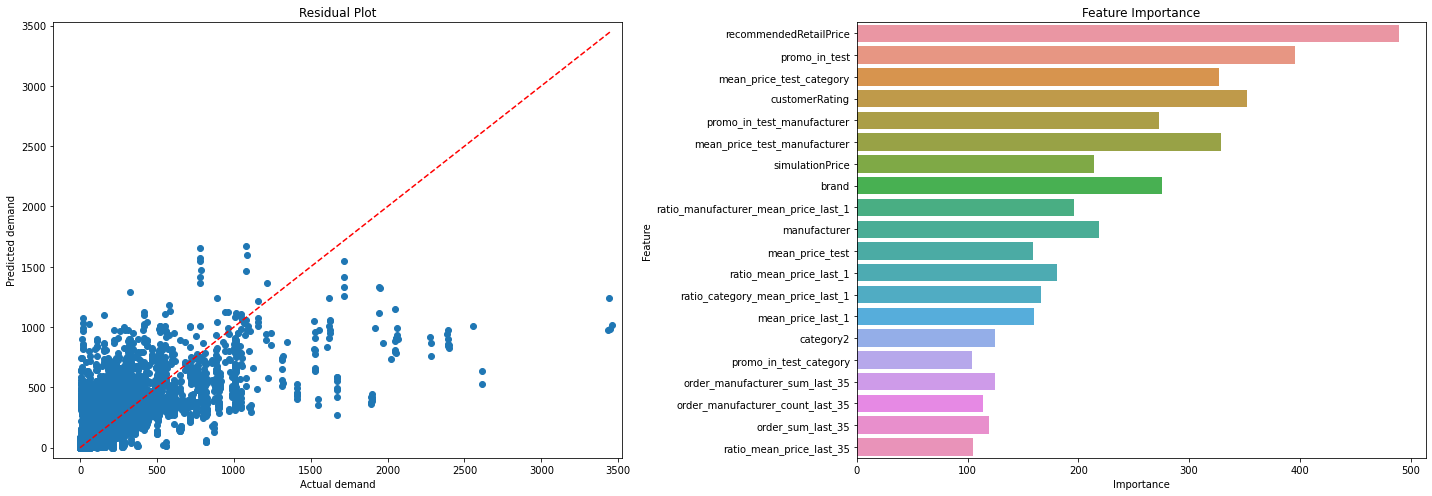

In [20]:
##### EVALUATION

fig = plt.figure(figsize = (20, 7))

# residual plot
plt.subplot(1, 2, 1)
plt.scatter(reals_oof.reshape(-1), preds_oof.reshape(-1))
axis_lim = np.max([reals_oof.max(), preds_oof.max()])
plt.ylim(top   = 1.02*axis_lim)
plt.xlim(right = 1.02*axis_lim)
plt.plot((0, axis_lim), (0, axis_lim), 'r--')
plt.title('Residual Plot')
plt.ylabel('Predicted demand')
plt.xlabel('Actual demand')

# feature importance
plt.subplot(1, 2, 2)
top_feats = 20
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False), ci = 0)
plt.title('Feature Importance')
plt.tight_layout()

# export
plt.savefig('lgb_performance.jpg')

In [29]:
clfs

[LGBMRegressor(bagging_fraction=0.8, boosting_type='goss', feature_fraction=0.8,
               lambda_l1=0.1, lambda_l2=0.1, metrics='None', n_estimators=1000,
               objective=<function asymmetric_mse at 0x000001E7B8589280>,
               random_state=23, verbosity=-1),
 LGBMRegressor(bagging_fraction=0.8, boosting_type='goss', feature_fraction=0.8,
               lambda_l1=0.1, lambda_l2=0.1, metrics='None', n_estimators=1000,
               objective=<function asymmetric_mse at 0x000001E7B8589280>,
               random_state=23, verbosity=-1),
 LGBMRegressor(bagging_fraction=0.8, boosting_type='goss', feature_fraction=0.8,
               lambda_l1=0.1, lambda_l2=0.1, metrics='None', n_estimators=1000,
               objective=<function asymmetric_mse at 0x000001E7B8589280>,
               random_state=23, verbosity=-1),
 LGBMRegressor(bagging_fraction=0.8, boosting_type='goss', feature_fraction=0.8,
               lambda_l1=0.1, lambda_l2=0.1, metrics='None', n_estimators

In [49]:
clf_classifier.booster_.save_model('clf.txt')

In [31]:
for i, model in enumerate(clfs):
    model.booster_.save_model(f'reg_fold_{i+1}.txt')

In [53]:
clf_model = lgb.Booster(model_file='clf.txt')
reg_model = lgb.Booster(model_file='reg.txt')

### Testing

In [3]:
df_test = pd.read_pickle(r'prepared/df_test.pkl')
print(df_test.shape)

(10463, 170)


In [21]:
preds_test

array([12.42857143, 19.42857143,  6.        , ...,  0.        ,
        1.        ,  0.85714286])

In [ ]:
preds_oof     = np.zeros((num_folds, items.shape[0]))
reals_oof     = np.zeros((num_folds, items.shape[0]))
prices_oof    = np.zeros((num_folds, items.shape[0]))
preds_test    = np.zeros(items.shape[0])
oof_rmse      = []
oof_profit    = []
oracle_profit = []
clfs          = []
train_idx     = []
valid_idx     = []

### Save Results

In [22]:
with open('saved/preds_oof.pkl', 'wb') as file:
    pickle.dump(preds_oof, file)

In [23]:
with open('saved/reals_oof.pkl', 'wb') as file:
    pickle.dump(reals_oof, file)

In [24]:
with open('saved/prices_oof.pkl', 'wb') as file:
    pickle.dump(prices_oof, file)

In [25]:
with open('saved/oof_rmse.pkl', 'wb') as file:
    pickle.dump(oof_rmse, file)

In [26]:
with open('saved/oof_profit.pkl', 'wb') as file:
    pickle.dump(oof_profit, file)

In [27]:
with open('saved/oracle_profit.pkl', 'wb') as file:
    pickle.dump(oracle_profit, file)

In [28]:
with open('saved/train_idx.pkl', 'wb') as file:
    pickle.dump(train_idx, file)

In [29]:
with open('saved/valid_idx.pkl', 'wb') as file:
    pickle.dump(valid_idx, file)

### Load Results

In [3]:
with open('saved/preds_oof.pkl', 'rb') as file:
    preds_oof = pickle.load(file)

In [4]:
with open('saved/reals_oof.pkl', 'rb') as file:
    reals_oof = pickle.load(file)

In [5]:
with open('saved/prices_oof.pkl', 'rb') as file:
    prices_oof = pickle.load(file)

In [6]:
with open('saved/oof_rmse.pkl', 'rb') as file:
    oof_rmse = pickle.load(file)

In [7]:
with open('saved/oof_profit.pkl', 'rb') as file:
    oof_profit = pickle.load(file)

In [8]:
with open('saved/oracle_profit.pkl', 'rb') as file:
    oracle_profit = pickle.load(file)

In [9]:
with open('saved/train_idx.pkl', 'rb') as file:
    train_idx = pickle.load(file)

In [10]:
with open('saved/preds_test.pkl', 'rb') as file:
    preds_test = pickle.load(file)

In [33]:
preds_oof[0]

array([  0.,   0., 142., ...,   0.,   0.,   0.])

In [34]:
preds_oof[1]

array([  0.,   0., 142., ...,   0.,   0.,   0.])

In [35]:
preds_oof[2]

array([0., 0., 1., ..., 0., 0., 0.])

In [36]:
preds_oof[2]

array([0., 0., 1., ..., 0., 0., 0.])

In [32]:
len(preds_oof[0])

10463

### Build df with pred

In [48]:
df_147 = pd.DataFrame({'itemID' : [i for i in range(1,10464)],
                'Truth' : reals_oof[19],
                'Pred' : preds_oof[19] })
df_147['day_of_year']=147
df_147.head()

,itemID,Truth,Pred,day_of_year
0,1,0.0,4.0,147
1,2,2.0,0.0,147
2,3,1.0,0.0,147
3,4,1.0,2.0,147
4,5,3.0,0.0,147


In [50]:
np.sqrt(mean_squared_error(df_147['Pred'],df_147['Truth']))

66.23432102368099

In [65]:
dfs = {}

def reversedEnumerate(l):
    return zip(range(len(l)-1, -1, -1), l)

for i in reversedEnumerate(range(147, 167)):
    df = pd.DataFrame({'itemID' : [i for i in range(1, 10464)],
                'Truth' : reals_oof[i[0]],
                'Pred' : preds_oof[i[0]] })
    df['day_of_year']=i[1]
    dfs[f'df_{i[1]}' ]=df

In [69]:
df = pd.concat(v for k, v in dfs.items())

In [70]:
df.head()

,itemID,Truth,Pred,day_of_year
0,1,0.0,4.0,147
1,2,2.0,0.0,147
2,3,1.0,0.0,147
3,4,1.0,2.0,147
4,5,3.0,0.0,147


In [71]:
len(df)

209260

In [74]:
df.to_pickle('saved/result_df.pkl')

In [3]:
result_df = pd.read_pickle(r'saved/result_df.pkl')

In [4]:
result_df.head()

,itemID,Truth,Pred,day_of_year
0,1,0.0,4.0,147
1,2,2.0,0.0,147
2,3,1.0,0.0,147
3,4,1.0,2.0,147
4,5,3.0,0.0,147


In [6]:
result_df.to_csv('result.csv')

In [9]:
result_df[result_df['itemID']==1002][['day_of_year', 'Truth', 'Pred']].set_index("day_of_year").sort_index(axis = 0)

,Truth,Pred
day_of_year,,
147,0.0,0.0
148,0.0,0.0
149,0.0,0.0
150,0.0,0.0
151,0.0,0.0
152,0.0,0.0
153,0.0,0.0
154,5.0,0.0
155,5.0,0.0


In [18]:
result = pd.read_csv('result.csv')

In [23]:
result.head()

,Unnamed: 0,itemID,Truth,Pred,day_of_year
0,0,1,0.0,4.0,147
1,1,2,2.0,0.0,147
2,2,3,1.0,0.0,147
3,3,4,1.0,2.0,147
4,4,5,3.0,0.0,147


In [39]:
# Overall RMSE
np.sqrt(mean_squared_error(result['Pred'], result['Truth']))

69.23171943422722

In [22]:
# Overall Profit

profits = []
for i in range(1, 10464):
    promotion_price = items[items['itemID']==i]['simulationPrice']
    truth = result[result['itemID']==i]['Truth']
    pred = result[result['itemID']==i]['Pred']
    pred = np.where(pred > 0, pred, 0)
    pred = np.round(pred).astype('int')
    sale = np.minimum(truth, pred)

    overstock = pred - truth
    overstock[overstock < 0] = 0

    revenue = sale * promotion_price
    fee     = overstock * promotion_price * 0.6
    profit  = revenue - fee
    profit  = profit.sum()
    profits.append(profit)

model_profit = 0
for i in profits:
    model_profit += i

model_profit

4527594.656000004

## Items with top profits (index+1)

arg_p = sorted(range(len(profits)), key=lambda x: profits[x])
arg_p[-20:]

In [33]:
np.argsort(profits)[-5:]

array([ 3357, 10059,  7941,   319,  4714], dtype=int64)